In [1]:
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp
import sys
from tqdm import tqdm
from utils import data_path
from base_network import neural_network
from poisson.poisson_utils import boundary_loss_factory, interior_loss_factory, crude_rel_L2


In [2]:
### Set files
name = str(sys.argv[1])
file = data_path / "poisson_single_pinn_train.json"
file_test = data_path / "poisson_single_pinn_test.json"
activation = np.tanh

### Set model (FFNN)
xpinn = XPINN(file, activation)
model = neural_network(activation)
v_model = vmap(model, (None, 0))

In [3]:

### Set true solution and RHS
@jit
def u_star(x):
    return np.prod(np.sin(np.pi * x))

# rhs
@jit
def f(x):
    return 2. * np.pi**2 * u_star(x)

In [4]:
f_v = f
f_final = jit(f_v)
# Set losses
p0 = xpinn.PINNs[0]
p0.boundary_loss = boundary_loss_factory(p0, 0)
p0.interior_loss = interior_loss_factory(p0, f_final)
p0.create_loss()
xpinn.set_loss()

In [5]:
### Initializing optimizer
shapes = [[2, 64, 1]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
    optimizer = optax.adam(learning_rate=exponential_decay)

    pinn.init_params(shape, optimizer)


In [6]:
### Setting iterations
n_iter = 200000
losses = xpinn.run_iters(n_iter)


0.00% iter = 0 of 200000: Total loss = 92.2465591430664
10.00% iter = 20000 of 200000: Total loss = 9.731049794936553e-05
20.00% iter = 40000 of 200000: Total loss = 4.4688466005027294e-05
30.00% iter = 60000 of 200000: Total loss = 3.8599016988882795e-05
40.00% iter = 80000 of 200000: Total loss = 3.7388734199339524e-05
50.00% iter = 100000 of 200000: Total loss = 3.624887176556513e-05
60.00% iter = 120000 of 200000: Total loss = 3.515597927616909e-05
70.00% iter = 140000 of 200000: Total loss = 3.410678982618265e-05
80.00% iter = 160000 of 200000: Total loss = 3.3108011848526075e-05
90.00% iter = 180000 of 200000: Total loss = 3.2146257581189275e-05
100.00% iter = 200000 of 200000: Total loss = 3.122702401014976e-05


(1, 200000)
92.24656
92.24656


Text(0.5, 1.0, 'Loss per Pinn over 200000 epochs')

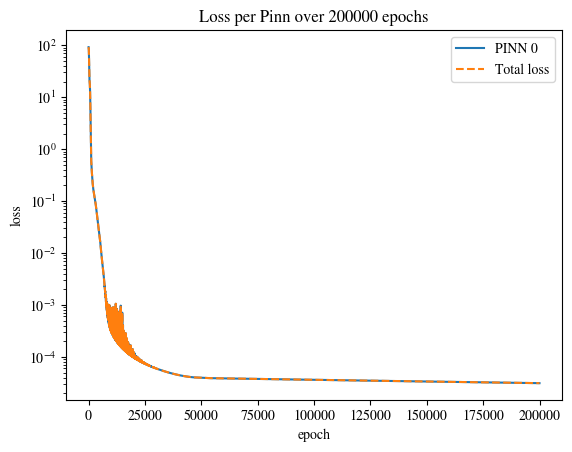

In [7]:
import matplotlib.pyplot as plt
import plotutils

a_losses = np.asarray(losses)
t_0 = 0
t = np.arange(t_0, n_iter)
print(a_losses.shape)
for i in range(2):
    print(a_losses[i,t_0])


for i in range(1):
    plt.plot(t, a_losses[i, t_0:], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

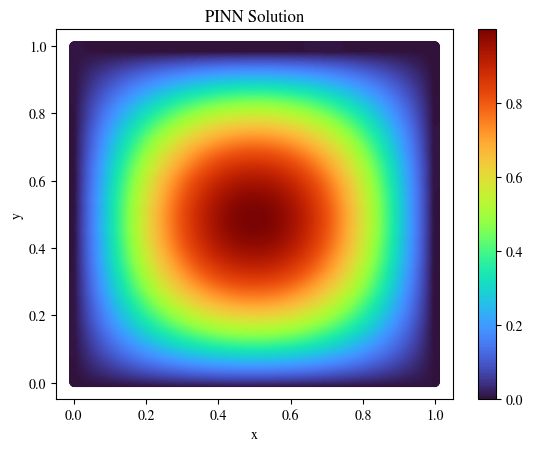

In [14]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
total_points = np.concatenate(points)
min_, max_ = total_pred.min(), total_pred.max()


for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="turbo")
    plt.clim(min_, max_)
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN Solution")
plt.colorbar()

In [9]:
u_vmap = vmap(u_star, (0))
true_value = u_vmap(total_points).reshape(-1, 1)

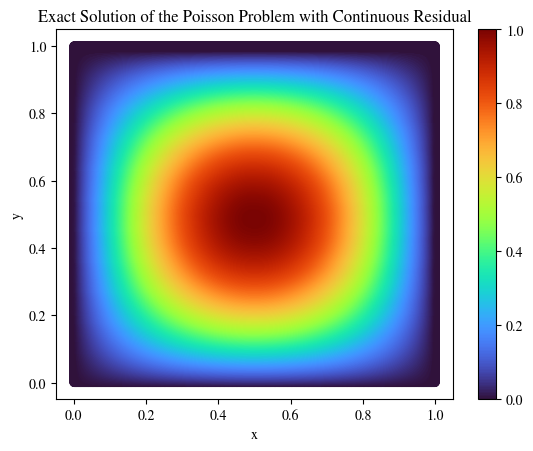

In [10]:
for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=true_value, cmap="turbo")
    plt.title("Exact Solution of the Poisson Problem with Continuous Residual")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.clim(0, 1)

plt.colorbar()

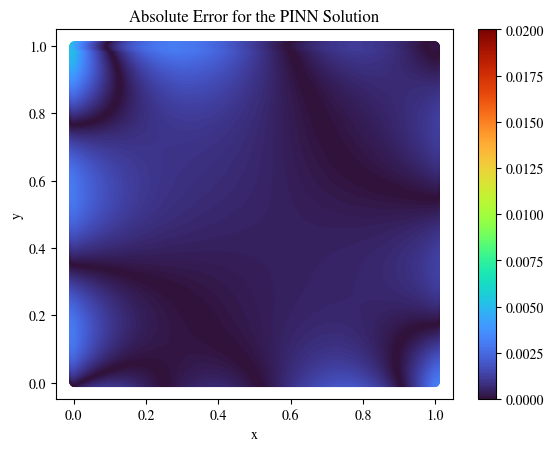

In [15]:

plt.scatter(total_points[:, 0], total_points[:, 1], c=np.abs(total_pred-true_value), cmap="turbo")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Absolute Error for the PINN Solution")
plt.clim(0, 0.02)

plt.colorbar()